In [ ]:
from tscode.utils import read_xyz, graphize, scramble_check, write_xyz
import os

os.chdir('/mnt/c/Users/Nick/Desktop/winscp_temp')

mol1 = read_xyz('MsNO2.xyz')
mol2 = read_xyz('propip.xyz')
mol3 = read_xyz('maybe_scrambled.xyz')
print(len(mol1.atomcoords[0]), len(mol2.atomcoords[0]),len(mol3.atomcoords[0]))

In [ ]:
graph1 = graphize(mol1.atomcoords[0], mol1.atomnos)
graph2 = graphize(mol2.atomcoords[0], mol2.atomnos)
graph3 = graphize(mol3.atomcoords[0], mol3.atomnos)
print(len(graph1.nodes), len(graph2.nodes),len(graph3.nodes))

In [ ]:
import numpy as np

In [ ]:
mols_graphs = [graph1, graph2]
constrained_indices = np.array([
    [4, 35],
    [36, 153], [37, 149]])
excluded_atoms = constrained_indices.ravel()
excluded_atoms

In [ ]:
from tscode.calculators._xtb import xtb_opt
opt_coords, energy, success = xtb_opt(
                mol3.atomcoords[0],
                # opt_coords,
                mol3.atomnos,
                # constrained_indices=constrained_indices,
                # constrained_distances=[None, 1.6, 1.6],
                constrained_indices=[constrained_indices[0]],
                constrained_distances=[None,],
                method='GFN2-XTB')
success

In [ ]:
energy

In [ ]:
bonds = set()
for i, graph in enumerate(mols_graphs):

    # pos = 0
    # while i != 0:
    #     pos += len(mols_graphs[i-1].nodes)
    #     i -= 1
    pos = sum([len(other_graph.nodes) for j, other_graph in enumerate(mols_graphs) if j < i])

    for bond in [tuple(sorted((a+pos, b+pos))) for a, b in list(graph.edges) if a != b]:
        bonds.add(bond)
# creating bond set containing all bonds present in the desired transition state

new_bonds = {tuple(sorted((a, b))) for a, b in list(graphize(opt_coords, mol3.atomnos).edges) if a != b}
delta_bonds = (bonds | new_bonds) - (bonds & new_bonds)
# delta_bonds -= {tuple(sorted(pair)) for pair in constrained_indices}

for bond in delta_bonds.copy():
    for a in excluded_atoms:
        if a in bond:
            delta_bonds -= {bond}
# removing bonds involving constrained atoms: they are not counted as scrambled bonds


In [ ]:
delta_bonds

In [ ]:
with open('optimized.xyz', 'w') as _f:
    write_xyz(opt_coords, mol3.atomnos, _f)

In [ ]:
with open('force_field_refining_tight_constraints.dat', 'r') as f:
    data = f.read()

In [ ]:
lines = [line.split(' : ')[1] for line in data.replace('\n [', ', [').split('\n') if len(line.split(' : ')) > 1]

In [ ]:
lines = [line.replace('[','').replace(',', '').replace(']','').split() for line in lines]

In [ ]:
lines = [[int(n) for n in line] for line in lines]

In [ ]:
ens_constr = np.array([[[l[0], l[1]], [l[2], l[3]]] for l in lines])
ens_constr[0]

In [ ]:
ens_structs = read_xyz('force_field_refining_tight_structures.xyz')
print(len(ens_structs.atomcoords), len(ens_constr))

In [ ]:
from tscode.utils import norm_of
import matplotlib.pyplot as plt
errors = []
for constraint, structure in zip(ens_constr, ens_structs.atomcoords):
    (a, b), (c, d) = constraint
    d1 = norm_of(
        structure[a]-
        structure[b]
    ) - 1.6
    d2 = norm_of(
        structure[c]-
        structure[d]
    ) - 1.6
    errors.append(d1+d2)
plt.hist(errors)

## LOADING EMBEDDER

In [ ]:
import os
import pickle
import numpy as np
from tscode.numba_functions import _score_embed_poses
os.chdir('/mnt/c/Users/Nick/Desktop/Computations/debug')

In [ ]:
with open('generate_candidates_runembedding.pickle', 'rb') as f:
    d = pickle.load(f)

In [ ]:
d['structures'].shape

In [ ]:
d['constrained_indices'][0]

In [ ]:
c_dists = np.array([[2.275, 2.275] for _ in d['structures']])

In [ ]:
scores = _score_embed_poses(
    d['structures'],
    d['constrained_indices'],
    c_dists,
)
scores[0:10]

In [ ]:
np.where(0.4 < scores and scores < np.max(scores))

In [ ]:
import matplotlib.pyplot as plt
plt.hist(scores)

In [ ]:
coords, _ = zip(*sorted(zip(d['structures'], scores), key=lambda x:x[1]))

In [ ]:
atomnos = read_xyz('worst.xyz').atomnos

In [ ]:
from tscode.utils import write_xyz, read_xyz
with open('sorted.xyz', 'w') as f:
    for c in coords[0:10]:
        write_xyz(c, atomnos, f)

In [ ]:
from tscode.utils import timing_wrapper
from concurrent.futures import ProcessPoolExecutor, as_completed

def func(a, b=None):
    return 2*a, 2*b

processes = []

with ProcessPoolExecutor(max_workers=1) as ex:
    p = ex.submit(
                    # payload_wrapper,
                    timing_wrapper,
                    func,
                    1,
                    b=2,
                    payload=(3,),
                )
    processes.append(p)
    
    for i, process in enumerate(as_completed(processes)):
        (a, b), (c,), t = p.result()

In [ ]:
print(a)
print(b)
print(c)
print(t)

## RMSD performance

In [1]:
from tscode.utils import read_xyz

data = read_xyz(f"/mnt/c/Users/Nick/Desktop/Computations/debug/TSCoDe_embedded_soft_ff_springs.xyz")
data.atomcoords.shape

(10000, 156, 3)

In [2]:
n = 10000
test_set = data.atomcoords[1:n]

In [3]:
import numba as nb
from numba import prange
import numpy as np
from tscode.algebra import norm_of

@nb.njit
def rmsd_and_max_numba(p, q):
    '''
    Returns a tuple with the RMSD between p and q
    and the maximum deviation of their positions

    '''
    
    # calculate the covariance matrix
    cov_mat = np.ascontiguousarray(p.T) @ q
    # cov_mat = np.transpose(p) * q
    
    # Compute the SVD
    v, _, w = np.linalg.svd(cov_mat)
    d = (np.linalg.det(v) * np.linalg.det(w)) < 0.0

    if d:
        v[:, -1] = -v[:, -1]

    # Create Rotation matrix u
    rot_mat = np.dot(v, w)

    # Apply it to p
    p = np.ascontiguousarray(p) @ rot_mat

    # Calculate deviations
    diff = p - q

    # Calculate RMSD
    rmsd = np.sqrt((diff * diff).sum() / len(diff))

    # # Calculate max deviation
    # max_delta = np.linalg.norm(diff, axis=1).max()
    max_delta = max([norm_of(v) for v in diff])

    return rmsd, max_delta

rmsd_and_max_numba(data.atomcoords[0], data.atomcoords[1])

(0.47513346810783985, 1.4835703657594594)

In [4]:
@nb.njit
def rmsd_similarity(ref, structures, in_mask, rmsd_thr, maxdev_thr):
    '''
    Returns True (as the int 1) if ref is similar to any
    structure in structures, returning at the first instance.
    Ignores structures that are False (0) in in_mask.

    '''

    for i in range(len(structures)):
        if in_mask[i]:
            rmsd_value, maxdev_value = rmsd_and_max_numba(ref, structures[i])
            if rmsd_value < rmsd_thr and maxdev_value < maxdev_thr:
                return 1
    return 0

@nb.njit
def similarity_mask_rmsd(structures, in_mask, rmsd_thr=0.25):
    '''
    '''
    maxdev_thr = 2 * rmsd_thr

    # initialize the result container
    out_mask = np.empty(shape=in_mask.shape, dtype=np.bool_)

    # loop over the structures
    for i, ref in enumerate(structures):

        # only check for similarity if the structure is active
        if in_mask[i]:

            # reject structure i if it is similar to any other after itself
            out_mask[i] = not rmsd_similarity(ref, structures[i+1:], in_mask[i+1:], rmsd_thr=rmsd_thr, maxdev_thr=maxdev_thr)

        else:
            out_mask[i] = 0

    return out_mask

@nb.njit(parallel=True)
def similarity_mask_rmsd_group(structures, in_mask, k, rmsd_thr=0.25):
    '''
    '''

    out_mask = np.empty(shape=structures.shape[0], dtype=np.bool_)
    chunksize = int(len(structures) // k)

    for chunk in prange(int(k)):
        first = chunk*chunksize
        if chunk == k-1:
            last = len(structures)
        else:
            last = chunksize*(chunk+1)

        # get the structure chunk
        structures_chunk = structures[first:last]
        # print(f"k={k}, {len(structures)} structs, chunk {chunk}: [{first}:{last}]")

        # compare structures within that chunk and save results to mask
        out_mask[first:last] = similarity_mask_rmsd(structures_chunk, in_mask[first:last], rmsd_thr=rmsd_thr)

    # print(len(chunks_pruned_structs), chunks_pruned_structs)
    return out_mask

def prune_conformers_rmsd_routine(structures, atomnos, rmsd_thr=0.25):
    '''
    '''
    heavy_atoms = (atomnos != 1)
    heavy_structures = np.array([structure[heavy_atoms] for structure in structures])
    out_mask = np.ones(shape=structures.shape[0], dtype=np.bool_)

    # split the structure array in subgroups and prune those
    for k in (5e5, 2e5, 1e5, 5e4, 2e4, 1e4,
              5000, 2000, 1000, 500, 200, 100,
              50, 20, 10, 5, 2, 1):
        
        # choose only k values such that every group
        # has at least five structures 
        if k == 1 or 5*k < len(structures):

            out_mask = similarity_mask_rmsd_group(heavy_structures, out_mask, k=k, rmsd_thr=rmsd_thr)

    return structures[out_mask], out_mask

_, mask = prune_conformers_rmsd_routine(data.atomcoords[0:30], data.atomnos, rmsd_thr=0.25)

In [5]:
data.atomcoords[0:30][mask].shape

(28, 156, 3)

In [6]:
rmsd_and_max_numba(data.atomcoords[24], data.atomcoords[27])

(0.24564874510697127, 0.45953796871284486)

In [7]:
%%time
n = 1000
rmsds = (0.25, 0.5, 0.75, 1, 1.5, 2, 2.5)
for rmsd in rmsds:
    prune_conformers_rmsd_routine(data.atomcoords[0:n], data.atomnos, rmsd_thr=rmsd)

CPU times: user 10.2 s, sys: 308 ms, total: 10.5 s
Wall time: 5.29 s


### trying to implement a cache to speed up things - it works!

In [7]:

from numba.core import types
from numba.typed import List, Dict

@nb.njit
def rmsd_similarity_cache(ref, structures, in_mask, cache, first_abs_index, rmsd_thr, maxdev_thr):
    '''
    Returns True (as the int 1) if ref is similar to any
    structure in structures, returning at the first instance of a match.
    Ignores structures that are False (0) in in_mask.

    '''

    computed_pairs = List()

    for i in range(len(structures)):

        # only compare active structures
        if in_mask[i]:

            # check if we have performed this computation already,
            # and in that case we know the structures were not similar,
            # since the in_mask attribute is not False for ref nor i
            hash_value = (first_abs_index, first_abs_index+1+i)
            if hash_value in cache:
                return 0, computed_pairs
            
            # if not compute the value and store the result in cache
            rmsd_value, maxdev_value = rmsd_and_max_numba(ref, structures[i])

            if rmsd_value < rmsd_thr and maxdev_value < maxdev_thr:
                computed_pairs.append(hash_value)
                return 1, computed_pairs
    return 0, computed_pairs

@nb.njit
def similarity_mask_rmsd_cache(structures, in_mask, cache, first_abs_index, rmsd_thr=0.25):
    '''
    '''
    maxdev_thr = 2 * rmsd_thr
    computed_pairs = List()

    # initialize the result container
    out_mask = np.empty(shape=in_mask.shape, dtype=np.bool_)

    # loop over the structures
    for i, ref in enumerate(structures):

        # only check for similarity if the structure is active
        if in_mask[i]:

            # reject structure i if it is similar to any other after itself
            similar, temp_computed_pairs = rmsd_similarity_cache(ref, structures[i+1:], in_mask[i+1:], cache=cache, first_abs_index=first_abs_index, rmsd_thr=rmsd_thr, maxdev_thr=maxdev_thr)
            out_mask[i] = not similar
            computed_pairs.extend(temp_computed_pairs)

        else:
            out_mask[i] = 0

    return out_mask, computed_pairs

@nb.njit
def similarity_mask_rmsd_group_cache(structures, in_mask, cache, k, rmsd_thr=0.25):
    '''
    '''
    computed_pairs = List()
    out_mask = np.empty(shape=structures.shape[0], dtype=np.bool_)
    chunksize = int(len(structures) // k)

    for chunk in range(int(k)):
        first = chunk*chunksize
        if chunk == k-1:
            last = len(structures)
        else:
            last = chunksize*(chunk+1)

        # get the structure chunk
        structures_chunk = structures[first:last]
        # print(f"k={k}, {len(structures)} structs, chunk {chunk}: [{first}:{last}]")

        # compare structures within that chunk and save results to mask
        out_mask[first:last], temp_computed_pairs = similarity_mask_rmsd_cache(structures_chunk, in_mask[first:last], cache=cache, first_abs_index=first, rmsd_thr=rmsd_thr)
        computed_pairs.extend(temp_computed_pairs)
    # print(len(chunks_pruned_structs), chunks_pruned_structs)
    return out_mask, computed_pairs

def prune_conformers_rmsd_routine_cache(structures, atomnos, rmsd_thr=0.25):
    '''
    '''
    heavy_atoms = (atomnos != 1)
    heavy_structures = np.array([structure[heavy_atoms] for structure in structures])
    out_mask = np.ones(shape=structures.shape[0], dtype=np.bool_)
    cache = List([(-1,-1)])

    # split the structure array in subgroups and prune those
    for k in (5e5, 2e5, 1e5, 5e4, 2e4, 1e4,
              5000, 2000, 1000, 500, 200, 100,
              50, 20, 10, 5, 2, 1):
        
        # choose only k values such that every group
        # has at least five structures 
        if k == 1 or 5*k < len(structures):

            out_mask, computed_pairs = similarity_mask_rmsd_group_cache(heavy_structures, out_mask, cache=cache, k=k, rmsd_thr=rmsd_thr)
            cache.extend(computed_pairs)
            # print(k, computed_pairs)

    return structures[out_mask], out_mask

_, mask = prune_conformers_rmsd_routine_cache(data.atomcoords[0:30], data.atomnos, rmsd_thr=0.25)

In [12]:
%%time
n = 1000
rmsds = (0.25, 0.5, 0.75, 1, 1.5, 2, 2.5)
for rmsd in rmsds:
    prune_conformers_rmsd_routine_cache(data.atomcoords[0:n], data.atomnos, rmsd_thr=rmsd)

CPU times: user 441 ms, sys: 8.86 ms, total: 450 ms
Wall time: 487 ms


In [ ]:
# %%time
# n = 1000
# rmsds = (0.25, 0.5, 0.75, 1, 1.5, 2, 2.5)
# for rmsd in rmsds:
#     prune_conformers_rmsd_routine_cache_par(data.atomcoords[0:n], data.atomnos, rmsd_thr=rmsd)

In [14]:
%%time
n = 1000
rmsds = (0.25, 0.5, 0.75, 1, 1.5, 2, 2.5)
for rmsd in rmsds:
    prune_conformers_rmsd_routine(data.atomcoords[0:n], data.atomnos, rmsd_thr=rmsd)

CPU times: user 7.62 s, sys: 304 ms, total: 7.92 s
Wall time: 2.69 s


In [15]:
_, mask1 = prune_conformers_rmsd_routine_cache(data.atomcoords[0:100], data.atomnos, rmsd_thr=0.5)
_, mask2 = prune_conformers_rmsd_routine_cache(data.atomcoords[0:100], data.atomnos, rmsd_thr=0.5)
all(m1 == m2 for m1, m2 in zip(mask1, mask2))

True

In [35]:
from tscode.numba_functions import prune_conformers_rmsd

In [ ]:
%%time
n = 1000
rmsds = (0.25, 0.5, 0.75, 1, 1.5, 2, 2.5)
for rmsd in rmsds:
    prune_conformers_rmsd(data.atomcoords[0:n], data.atomnos, max_rmsd=rmsd)

CPU times: user 8.98 s, sys: 0 ns, total: 8.98 s
Wall time: 9.73 s


0.25 A, kept 644/1000
0.5 A, kept 463/1000
0.75 A, kept 208/1000
1 A, kept 163/1000
1.5 A, kept 31/1000
0.25 A, kept 413/1000
0.5 A, kept 173/1000
0.75 A, kept 46/1000
1 A, kept 21/1000
1.5 A, kept 15/1000


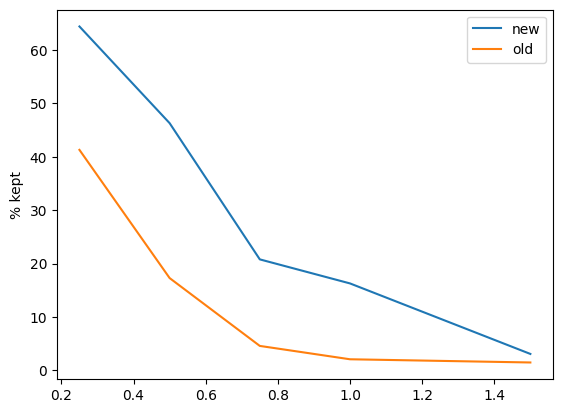

In [ ]:
n = 1000
kept = []
rmsds = (0.25, 0.5, 0.75, 1, 1.5)
for rmsd in rmsds:
    kp = np.count_nonzero(prune_conformers_rmsd_routine_cache(data.atomcoords[0:n], data.atomnos, rmsd_thr=rmsd)[1] == True)
    kept.append(kp/n*100)
    print(f"{rmsd} A, kept {kp}/{n}")

plt.plot(rmsds, kept, label="new")

kept = []
for rmsd in rmsds:
    kp = np.count_nonzero(prune_conformers_rmsd(data.atomcoords[0:n], data.atomnos, max_rmsd=rmsd)[1] == True)
    kept.append(kp/n*100)
    print(f"{rmsd} A, kept {kp}/{n}")

plt.plot(rmsds, kept, label="old")

plt.ylabel("% kept")
plt.legend()

In [8]:
@nb.njit(parallel=True)
def similarity_mask_rmsd_group_cache_par(structures, in_mask, cache, k, rmsd_thr=0.25):
    '''
    '''
    computed_pairs = List([List([(-1,-1)]) for _ in range(k)])
    final_computed_pairs = List()
    out_mask = np.empty(shape=structures.shape[0], dtype=np.bool_)
    chunksize = int(len(structures) // k)

    for chunk in prange(int(k)):
        first = chunk*chunksize
        if chunk == k-1:
            last = len(structures)
        else:
            last = chunksize*(chunk+1)

        # get the structure chunk
        structures_chunk = structures[first:last]
        # print(f"k={k}, {len(structures)} structs, chunk {chunk}: [{first}:{last}]")

        # compare structures within that chunk and save results to mask
        out_mask[first:last], computed_pairs[chunk] = similarity_mask_rmsd_cache(structures_chunk, in_mask[first:last], cache=cache, first_abs_index=first, rmsd_thr=rmsd_thr)
        # out_mask[first:last], temp_computed_pairs = similarity_mask_rmsd_cache(structures_chunk, in_mask[first:last], cache=cache, first_abs_index=first, rmsd_thr=rmsd_thr)
        # computed_pairs.extend(temp_computed_pairs)
        # computed_pairs[] = ([(-1,-1)])
    # print(len(chunks_pruned_structs), chunks_pruned_structs)
    for L in computed_pairs:
        final_computed_pairs.extend(L)
    return out_mask, final_computed_pairs

def prune_conformers_rmsd_routine_cache_par(structures, atomnos, rmsd_thr=0.25):
    '''
    '''

    # only consider non-hydrogen atoms
    heavy_atoms = (atomnos != 1)
    heavy_structures = np.array([structure[heavy_atoms] for structure in structures])

    # initialize the output mask
    out_mask = np.ones(shape=structures.shape[0], dtype=np.bool_)
    cache = List([(-1,-1)])

    # split the structure array in subgroups and prune them internally
    for k in (5e5, 2e5, 1e5, 5e4, 2e4, 1e4,
              5000, 2000, 1000, 500, 200, 100,
              50, 20, 10, 5, 2, 1):
        
        # choose only k values such that every subgroup
        # has at least five structures in it
        if k == 1 or 5*k < len(structures):

            # compute similarities and get back the out_mask
            # and the pairings to be added to cache
            out_mask, computed_pairs = similarity_mask_rmsd_group_cache_par(
                                                                            heavy_structures,
                                                                            out_mask,
                                                                            cache=cache,
                                                                            k=k,
                                                                            rmsd_thr=rmsd_thr,
                                                                            )
            # extend the cache set with the new pairings we computed
            cache.extend(computed_pairs)

    return structures[out_mask], out_mask

_, mask = prune_conformers_rmsd_routine_cache_par(data.atomcoords[0:50], data.atomnos, rmsd_thr=0.25)

In [23]:
%%time
n = 10000
rmsds = (0.25, 0.5, 0.75, 1, 1.5, 2, 2.5)
for rmsd in rmsds:
    prune_conformers_rmsd_routine_cache_par(data.atomcoords[0:n], data.atomnos, rmsd_thr=rmsd)

CPU times: user 33.7 s, sys: 2.68 s, total: 36.4 s
Wall time: 6.96 s


In [22]:
%%time
n = 10000
rmsds = (0.25, 0.5, 0.75, 1, 1.5, 2, 2.5)
for rmsd in rmsds:
    prune_conformers_rmsd_routine_cache(data.atomcoords[0:n], data.atomnos, rmsd_thr=rmsd)

CPU times: user 7.47 s, sys: 0 ns, total: 7.47 s
Wall time: 8.1 s


In [15]:
_, mask1 = prune_conformers_rmsd_routine_cache(data.atomcoords[0:100], data.atomnos, rmsd_thr=0.5)
_, mask2 = prune_conformers_rmsd_routine_cache_par(data.atomcoords[0:100], data.atomnos, rmsd_thr=0.5)
all(m1 == m2 for m1, m2 in zip(mask1, mask2))

True

In [24]:
%%timeit
prune_conformers_rmsd_routine_cache(data.atomcoords, data.atomnos, rmsd_thr=1.0)

1.02 s ± 36.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
%%timeit
prune_conformers_rmsd_routine_cache_par(data.atomcoords, data.atomnos, rmsd_thr=1.0)

607 ms ± 22.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%%timeit
prune_conformers_rmsd(data.atomcoords, data.atomnos, max_rmsd=1.0)

20.8 s ± 459 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
20.8/0.607

34.2668863261944

In [27]:
%load_ext memory_profiler

In [29]:
%%memit
prune_conformers_rmsd_routine_cache(data.atomcoords, data.atomnos, rmsd_thr=1.0)

peak memory: 464.88 MiB, increment: 0.00 MiB


In [33]:
%%memit
prune_conformers_rmsd_routine_cache_par(data.atomcoords, data.atomnos, rmsd_thr=1.0)

peak memory: 497.38 MiB, increment: 0.00 MiB


In [2]:
from tscode.utils import read_xyz
cy = read_xyz(f"/mnt/c/Users/Nick/Desktop/Computations/debug/MeCy_confs.xyz")
cy.atomcoords.shape

(4, 21, 3)

In [4]:
from tscode.rmsd_pruning import prune_conformers_rmsd
import numpy as np

for rmsd in (0.25, 0.5, 0.75, 1, 1.25, 1.5):
    _, mask = prune_conformers_rmsd(cy.atomcoords, cy.atomnos, rmsd_thr=rmsd)
    print(f"RMSD_THR {rmsd}, kept {np.count_nonzero(mask)}/4")

RMSD_THR 0.25, kept 4/4
RMSD_THR 0.5, kept 4/4
RMSD_THR 0.75, kept 3/4
RMSD_THR 1, kept 2/4
RMSD_THR 1.25, kept 2/4
RMSD_THR 1.5, kept 2/4


### CENSO cpu test

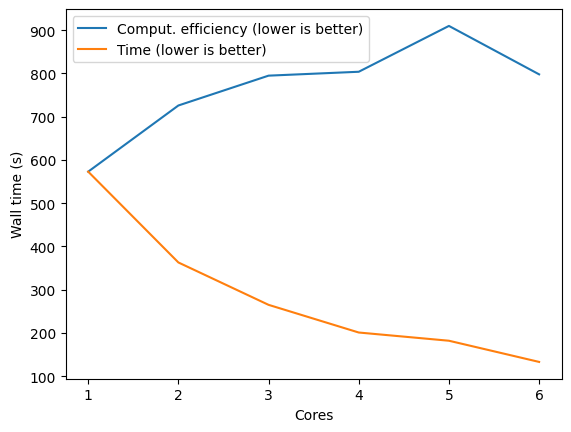

In [25]:
import matplotlib.pyplot as plt
c = [1,2,3,4,5,6]
t = [9*60+33, 6*60+3, 4*60+25, 3*60+21, 3*60+2, 2*60+13]
s = [t_*c_ for t_, c_ in zip(t,c)]
plt.plot(c,s, label="Comput. efficiency (lower is better)")
plt.plot(c,t, label="Time (lower is better)")
plt.xlabel("Cores")
plt.ylabel("Wall time (s)")
plt.legend()

In [22]:
from tscode.utils import time_to_string

n_structs = 400
procs = 36

for procs_per_job in range(1,7):
    n_concurrent = procs/procs_per_job
    print(f"{procs_per_job} cores, {int(n_concurrent)} concurrent: {time_to_string(t[procs_per_job-1]*n_structs/(n_concurrent))}")

1 cores, 36 concurrent: 1 h 46 m 6.7 s
2 cores, 18 concurrent: 2 h 14 m 26.7 s
3 cores, 12 concurrent: 2 h 27 m 13.3 s
4 cores, 9 concurrent: 2 h 28 m 53.3 s
5 cores, 7 concurrent: 2 h 48 m 31.1 s
6 cores, 6 concurrent: 2 h 27 m 46.7 s


### XTB cpu test

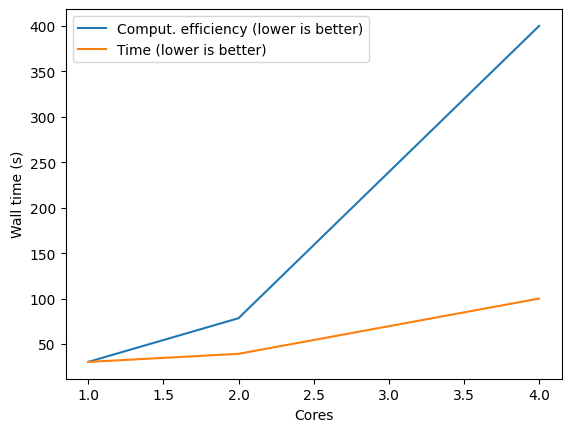

In [39]:
import matplotlib.pyplot as plt
import numpy as np
c = [1,2,4]
t = [30.3, 39.2, 100]
s = [t_*c_ for t_, c_ in zip(t,c)]
plt.plot(c,s, label="Comput. efficiency (lower is better)")
plt.plot(c,t, label="Time (lower is better)")
plt.xlabel("Cores")
plt.ylabel("Wall time (s)")
plt.legend()

In [32]:
time_to_string(45_000*45_000*1/55000)

'10 h 13 m 38.2 s'

In [35]:
1/55000*1000*1000

18.18181818181818

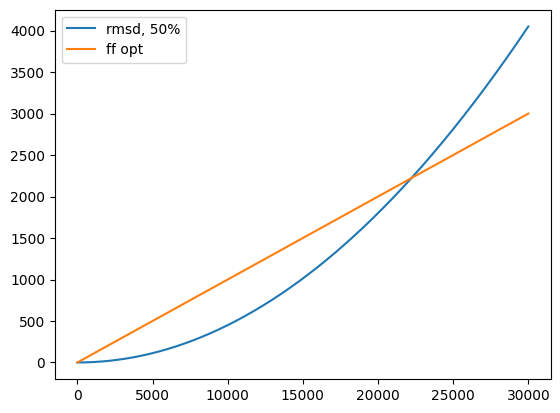

In [48]:
t_rmsd = 18E-6
t_opt = 0.1
t_opt2 = 7

x = np.arange(3E4)
y_rmsd_100 = x**2 * t_rmsd
y_rmsd_50 = y_rmsd_100 / 2**2
y_opt = x * t_opt
y_opt2 = x * t_opt2

# plt.plot(x, y_rmsd_100, label="rmsd, 100%")
plt.plot(x, y_rmsd_50, label="rmsd, 50%")
plt.plot(x, y_opt, label="ff opt")
plt.legend()

In [5]:
from tscode.utils import read_xyz
from tscode.rmsd_pruning import prune_conformers_rmsd
import numpy as np

sample = read_xyz(f"/mnt/c/Users/Nick/Desktop/Computations/debug/MeCy_confs.xyz")
sample.atomcoords.shape

(4, 21, 3)

In [6]:
for rmsd in (0.5, 0.75, 1, 1.25, 1.5, 2, 2.5, 3, 3.5, 4):
    _, mask = prune_conformers_rmsd(sample.atomcoords, sample.atomnos, rmsd_thr=rmsd)
    print(f"RMSD_THR {rmsd}, kept {np.count_nonzero(mask)}/10")

RMSD_THR 0.5, kept 4/10
RMSD_THR 0.75, kept 3/10
RMSD_THR 1, kept 2/10
RMSD_THR 1.25, kept 2/10
RMSD_THR 1.5, kept 2/10
RMSD_THR 2, kept 2/10
RMSD_THR 2.5, kept 2/10
RMSD_THR 3, kept 2/10
RMSD_THR 3.5, kept 1/10
RMSD_THR 4, kept 1/10


In [23]:
from tscode.utils import read_xyz
import os
os.chdir("/mnt/c/Users/Nick/Desktop/Computations/7_mem_targets/strain_energy")
filenames = []
for file in os.listdir():
    if file.endswith(".xyz"):
        filenames.append(file)

filenames

['F1.xyz',
 'F10.xyz',
 'F11.xyz',
 'F12.xyz',
 'F13.xyz',
 'F2.xyz',
 'F3.xyz',
 'F4.xyz',
 'F5.xyz',
 'F6.xyz',
 'F7.xyz',
 'F8.xyz',
 'F9.xyz',
 'S1.xyz',
 'S1prime.xyz',
 'S1prime_trans.xyz',
 'S2.xyz',
 'S2prime.xyz',
 'S2prime_trans.xyz',
 'S3.xyz',
 'S3prime.xyz',
 'S3prime_trans.xyz',
 'S4.xyz',
 'S4prime.xyz',
 'S4prime_trans.xyz',
 'S5.xyz',
 'S5prime.xyz',
 'S5_ent.xyz',
 'S5_mep.xyz',
 'S5_ts_guess.xyz',
 'S5_tub.xyz',
 'S6.xyz',
 'S6prime.xyz',
 'S7.xyz',
 'S7prime.xyz']

In [24]:
mols = [read_xyz(filename) for filename in filenames]

In [19]:
from tscode.pt import pt

In [31]:
import numpy as np

def _saturation_index(atomnos):
        # does not work with P/S(?) - they can be either hypervalent or not
        C = np.count_nonzero(atomnos == 6)
        H = np.count_nonzero(atomnos == 1)
        N = np.count_nonzero(atomnos == 7)
        O = np.count_nonzero(atomnos == 8)
        F = np.count_nonzero(atomnos == 9)
        Cl = np.count_nonzero(atomnos == 17)
        Br = np.count_nonzero(atomnos == 35)
        I = np.count_nonzero(atomnos == 53)

        SI = C - (H + F + Cl + Br + I)/2 + N/2 + 1

        proper = True if C + N + O != 0 else False

        if proper:
            return SI

        return 0.5


def _saturation_check(atomnos, charge=0, embedder=None):

    transition_metals = [
                    "Sc", "Ti", "V", "Cr", "Mn", "Fe",
                    "Co", "Ni", "Cu", "Zn", "Y", "Zr",
                    "Nb", "Mo", "Tc", "Ru", "Rh", "Pd",
                    "Ag", "Cd", "La", "Ce", "Pr", "Nd",
                    "Pm", "Sm", "Eu", "Gd", "Tb", "Dy",
                    "Ho", "Er", "Tm", "Yb", "Lu", "Hf",
                    "Ta", "W", "Re", "Os", "Ir", "Pt",
                    "Au", "Hg", "Th", "Pa", "U", "Np",
                    "Pu", "Am", 
    ]

    # if we have any transition metal, it's hard to tell
    # if the structure looks ok: in this case we assume it is.
    organometallic = any([pt[a].symbol in transition_metals for a in atomnos])

    odd_valent = [  #1 valent
                    "H", "Li", "Na", "K", "Rb", "Cs",
                    "F", "Cl", "Br", "I", "At",

                    # 3/5 valent
                    "N", "P", "As", "Sb", "Bi",
                    "B", "Al", "Ga", "In", "Tl",
                 ]

    n_odd_valent = sum([1 for a in atomnos if pt[a].symbol in odd_valent])
    looks_ok = ((n_odd_valent + charge) / 2) % 1 < 0.001 if not organometallic else True

    if embedder is not None:
        if looks_ok:
            embedder.log(f"--> Molecular check passed: input structure has an even saturation index")

        else:
            s = f"--> WARNING! Molecular check failed: input structure has an odd saturation index (charge={charge}). Radical or bad input geometry?"
            embedder.log(s)
            embedder.warnings.append(s)

    return looks_ok


passed = np.count_nonzero([_saturation_check(mol.atomnos) for mol in mols])
f"passed {passed}/{len(mols)}"

'passed 35/35'

In [27]:
46.5 % 1

0.5

## safest opt

In [1]:
from tscode.utils import read_xyz, write_xyz
from tscode.numba_functions import compenetration_check
import numpy as np

mol = read_xyz('/mnt/c/Users/Nick/Downloads/report_mtd_confs.xyz')
comp = [c for c, coords in enumerate(mol.atomcoords) if not compenetration_check(coords)]
comp

[195]

In [28]:
mol2 = read_xyz('/mnt/c/Users/Nick/Downloads/dixon_mtd_confs.xyz')
comp = [c for c, coords in enumerate(mol2.atomcoords) if not compenetration_check(coords)]
print(f"Comp are {len(comp)}/{len(mol2.atomcoords)}")

Comp are 0/1140


In [3]:
from tscode.calculators._xtb import xtb_pre_opt, xtb_opt
from tscode.utils import graphize

graph = graphize(mol.atomcoords[0], mol.atomnos)
opt_coords, _, _ = xtb_pre_opt(mol.atomcoords[195], mol.atomnos, [graph], method="GFN-FF", solvent="CH2Cl2")

with open('/mnt/c/Users/Nick/Downloads/safe.xyz', 'w') as f:
    write_xyz(opt_coords, mol.atomnos, f)

In [5]:
opt_coords, _, _ = xtb_opt(mol.atomcoords[195], mol.atomnos, method="GFN-FF", solvent="CH2Cl2")

with open('/mnt/c/Users/Nick/Downloads/free.xyz', 'w') as f:
    write_xyz(opt_coords, mol.atomnos, f)

In [26]:
opt_coords, _, _ = xtb_opt(mol.atomcoords[195], mol.atomnos, method="GFN2-XTB", solvent="CH2Cl2")

with open('/mnt/c/Users/Nick/Downloads/free_gfn2.xyz', 'w') as f:
    write_xyz(opt_coords, mol.atomnos, f)

In [10]:
graph0 = graphize(mol.atomcoords[0], mol.atomnos)
graph195 = graphize(mol.atomcoords[195], mol.atomnos)
get_extra_bonds(graph195, graph0)

[]

In [23]:
from tscode.algebra import norm_of
norm_of(mol.atomcoords[195][24]-mol.atomcoords[195][71])

0.8509350561494103

In [17]:
len(graph195.edges)

245

In [25]:
d_min_bond(1,1)

0.744

In [24]:
from tscode.graph_manipulations import get_sum_graph, d_min_bond

def get_extra_bonds(graph, ref_graph):
    '''
    returns a list of atomic pairs that appear at a bonding
    distance even though they should not based on the 
    reference molecular graph.

    '''
    return [edge for edge in graph.edges if edge not in ref_graph.edges]

def xtb_safe_opt(
                coords,
                atomnos, 
                graphs,
                constrained_indices=None,
                constrained_distances=None, 
                **kwargs,
                ):
    '''
    Wrapper for xtb_opt that:
    - preserves the distance of every bond present in each subgraph provided.
    - repels atoms that should not be bonded if they are too close.

    graphs: list of subgraphs that make up coords, in order

    '''
    sum_graph = get_sum_graph(graphs, extra_edges=constrained_indices)

    # we have to check through a list this way, as I have not found
    # an analogous way to check through an array for subarrays in a nice way
    list_of_constr_ids = [[a,b] for a, b in constrained_indices] if constrained_indices is not None else []

    constrain_string = "$constrain\n"
    for constraint in [[a, b] for (a, b) in sum_graph.edges if a!=b]:

        if constrained_distances is None:
            distance = 'auto'

        elif constraint in list_of_constr_ids:
            distance = constrained_distances[list_of_constr_ids.index(constraint)]

        else:
            distance = 'auto'

        indices_string = str([i+1 for i in constraint]).strip("[").strip("]")
        constrain_string += f"  distance: {indices_string}, {distance}\n"
    constrain_string += "\n$end"

    return xtb_opt(
                    coords,
                    atomnos,
                    constrained_indices=constrained_indices,
                    constrained_distances=constrained_distances,
                    constrain_string=constrain_string,
                    **kwargs,
                )